In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (8,6)
plt.rc('font', family='Arial')
# plt.style.use('ggplot')

## Методы оптимизации

Как было показано на лекции, большинство методов машинного обучения сводятся к поиску параметров, которые минимизируют ошибку на тренировочной выборке:
$$
\min_{w} L(w; D)
$$
Здесь:
* $D$ — размеченная обучающая выборка, $\{x_i, y_i\}_{i=1}^N$
* $L$ — функция потерь
* $w$ — настраиваемые веса алгоритма

В более общем виде задачу можно записать так:
$$
\min_{x} f(x)
$$
Здесь:
* $x$ — вектор значений
* $f$ — функция, принимающая вектор в качестве аргумента и выдающая числовое значение.

На семинаре рассмотрим подробнее методы минимизации функции, которые рассматривались на лекции.

## Градиентный спуск

Для оптимизации возьмем простую функцию $f(x) = x^3 - 2x^2 + 2$

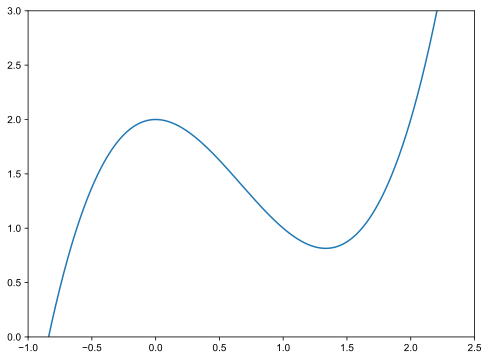

In [3]:
f = lambda x: x ** 3 - 2*x ** 2 + 2
df = lambda x: 3 * x ** 2 - 4 * x # производная
x = np.linspace(-1, 2.5, 1000)
__ = plt.plot(x, f(x))
__ = plt.xlim([-1, 2.5])
__ = plt.ylim([0, 3])
__ = plt.show()

И определим функцию, которая будет оптимизировать функцию $f(x)$ градиентным спуском с заданным постоянным шагом (он же learning rate, темп обучения).

In [32]:
def optimize_and_plot_steps(learning_rate, x_new=2, compute_learning_rate=None):
    x_old = 0
    # x_new — точка старта
    eps = 0.0001
    x_list, y_list = [x_new], [f(x_new)] # инициализируем список координат и значений функций при итерации
    
    # спускаемся, пока разница между координатами не достигла требуемой точности
    i = 0
    while abs(x_new - x_old) > eps:
        # обновляем значение темпа обучения, если нам задана функция для этого
        if compute_learning_rate is not None:
            learning_rate = compute_learning_rate(i, learning_rate)
            
        x_old = x_new
        # считаем направление спуска
        direction = df(x_new)
        step = learning_rate*direction
        # делаем шаг
        x_new = x_old - step
        
        # запоминаем очередной шаг минимизации
        x_list.append(x_new)
        y_list.append(f(x_new))
        i += 1
        
    print("Найденный локальный минимум:", x_new)
    print("Количество шагов:", len(x_list))
    
    __ = plt.figure(figsize=[10,3])
    
    __ = plt.subplot(1,2,1)
    __ = plt.scatter(x_list, y_list, c="r", edgecolors='k')
    __ = plt.plot(x_list, y_list, c="r")
    __ = plt.plot(x, f(x), c="b")
    __ = plt.xlim([-1,2.5])
    __ = plt.ylim([0,3])
    __ = plt.title("Descent trajectory")

    __ = plt.subplot(1,2,2)
    __ = plt.scatter(x_list,y_list,c="r", edgecolors='k')
    __ = plt.plot(x_list,y_list,c="r")
    __ = plt.plot(x,f(x), c="b")
    __ = plt.xlim([1.2,2.1])
    __ = plt.ylim([0,3])
    __ = plt.title("Descent trajectory (zoomed in)")
    __ = plt.show()

Попробуем оптимизацию с шагом 0.1

Найденный локальный минимум: 1.3334253508453249
Количество шагов: 17


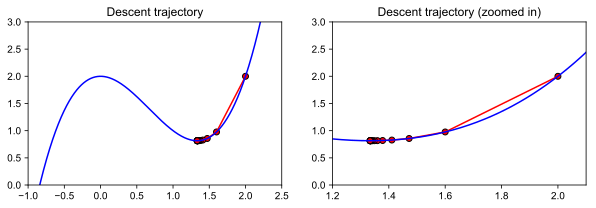

Найденный локальный минимум: 1.3333196313538374
Количество шагов: 8


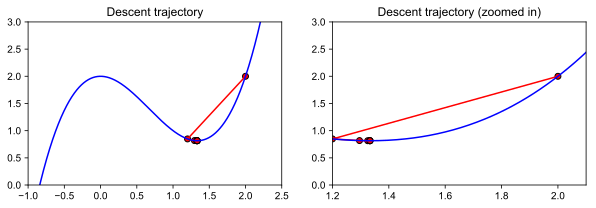

In [39]:
optimize_and_plot_steps(0.1)
optimize_and_plot_steps(0.2)

Возьмем шаг побольше.

Найденный локальный минимум: 1.3333020223878838
Количество шагов: 15


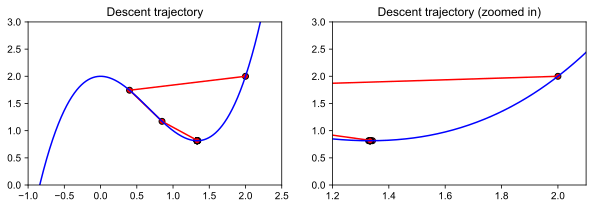

In [34]:
optimize_and_plot_steps(0.4)

Что, если взять 0.5?

Найденный локальный минимум: 0.0
Количество шагов: 3


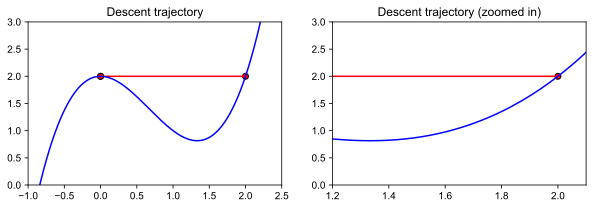

In [35]:
optimize_and_plot_steps(0.5)

Застопорились в нуле, т.к. нашли точный локальный максимум. В нем производная равна нулю и мы никуда не можем сдвинуться. А если взять 0.49?

Найденный локальный минимум: 1.3333812706364907
Количество шагов: 188


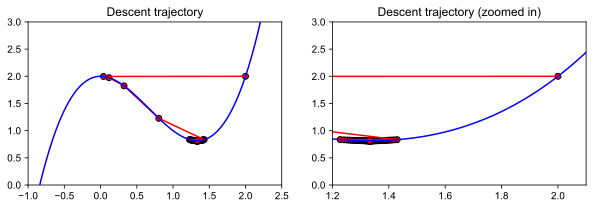

In [36]:
optimize_and_plot_steps(0.49)

Что, если взять 0.51?

In [37]:
optimize_and_plot_steps(0.51)

OverflowError: (34, 'Result too large')

Мы улетели далеко влево. Это можно понять, распечатав значения x_new.

Теперь возьмём маленький шаг. Например, 0.05.

Найденный локальный минимум: 1.3337297312792562
Количество шагов: 32


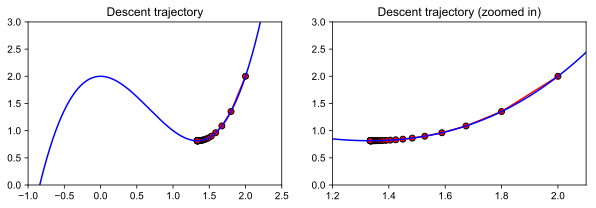

In [40]:
optimize_and_plot_steps(0.05)

0.01?

Найденный локальный минимум: 1.3356881625009205
Количество шагов: 129


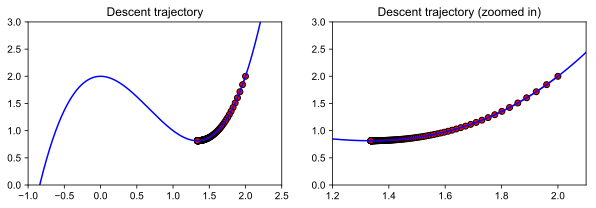

In [41]:
optimize_and_plot_steps(0.01)

Чем меньше шаг, тем медленнее мы идём к минимум (и можем вдобавок застрять по пути). Чем больше темп обучения, тем большие расстояния мы перепрыгиваем (и имеем гипотетическую возможность найти минимум получше). Хорошая стратегия — начинать с достаточно большого шага (чтобы хорошо попутешествовать по функции), а потом постепенно его уменьшать, чтобы стабилизировать процесс обучения в каком-то локальном минимуме.

Теперь будем изменять шаг динамически:
$lr(i + 1) = lr(i) * 0.9$.

In [42]:
def compute_learning_rate(i, prev_lr):
    return prev_lr * 0.9

Найденный локальный минимум: 1.3333376009455882
Количество шагов: 7


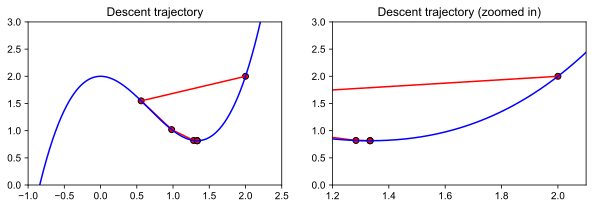

In [43]:
optimize_and_plot_steps(0.4, compute_learning_rate=compute_learning_rate)

Если сравнивать с постоянным темпом обучения, то мы нашли минимум в 2 раза быстрее.

Найденный локальный минимум: 1.3333020223878838
Количество шагов: 15


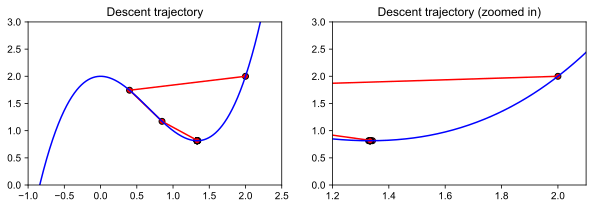

In [44]:
optimize_and_plot_steps(0.4)

Это, конечно, искуственный пример, но такая же идея используются для обучения алгоритмов машинного обучения с миллионами параметров, функции потерь которых имеют очень сложную структуру и не поддаются визуализации.

## Настройка линейной регрессии с помощью градиентного спуска

Рассмотрим теперь реальные данные и попробуем использовать градиентный спуск для решения задачи линейной регрессии.

Загрузите файл food_trucks.txt. В нём два столбца значений — количество жителей в городе и доход грузовика с уличной едой в этом городе.

In [46]:
X_food = pd.read_csv(r'data/food_trucks.txt')
X_food.head()

6.1101   17.592
0  5.5277   9.1302
1  8.5186  13.6620
2  7.0032  11.8540
3  5.8598   6.8233
4  8.3829  11.8860

Визуализируйте данные. По оси X — население города, по оси Y — доход грузовика.

Вспомним функцию потерь линейной регрессии:
$$
L(w) = \frac{1}{2m} \sum_{i=1}^m (h(x^i, w) - y^i)^2
$$
Здесь $h(x, w) = w^Tx = w_0 + w_1 x_1$ (предполагается, что $x_0=1$ — дополнительный признак для удобства).
$(x^i, y^i)$ — i-ый объект выборки.
Тогда правило обновления весов будет выглядеть следующим образом:
$$
w_j = w_j - \eta \cdot \frac{1}{m}\sum_{i=1}^m(h(x^i, w) - y^i) x^i_j.
$$
Здесь $x^i_j$ — j-ая компонента i-ого объекта.

Определите функцию потерь и её производную. Эти функции имеют один аргумент — вектор весов $w$.

Напишите функцию минимизации $L(w)$ с помощью градиентного спуска, аналогичную optimize_and_plot_steps. На вход она принимает параметры обучения (темп обучения и начальное значение весов), оптимизирует итеративно функцию потерь, печатает итерации и визуализирует уменьшение функции потерь и найденное решение. Запустите функцию с постоянным темпом обучения и прокомментируйте результаты.

Измените функцию минимизации так, чтобы темп обучения мог меняться динамически, аналогично примеру выше. Запустите функцию и прокомментируйте результаты.

## Линейная регрессия с батч-оптимизацией

Теперь рассмотрим случай, когда данных в выборке много. В таких случаях используется стохастическая или батч-оптимизация. Первая состоит в том, что на каждом шаге итерации берется один объект, вторая — в том, что берется некоторое небольшое фиксированное количество объектов.

Загрузите данные из файла space_ga.csv и нормализуйте их. Мы будем предсказывать первый столбец по шести остальным. Эти данные получены с выборов в США в 1980 году. Подробнее о столбцах можно прочитать тут: http://mldata.org/repository/data/viewslug/statlib-20050214-space_ga/

Как вы могли заметить, датасет больше предыдущего. На нём мы попробуем батч-оптимизацию.

Измените функцию минимизации так, чтобы на вход они принимала дополнительный параметр — размер батча. Для простоты проверки рекомендуется изменять копию функции, реализованной выше, с измененным именем. Запустите функцию при разных размерах батча. Прокомментируйте результаты.